In [1]:
import ijson
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
NUM_OF_FILES = 214314
extractors = {'hdf', 'netcdf', 'keyword', 'images', 'tabular', 'jsonxml', 'python', 'c-code'}

times_dict = dict()
for extractor in extractors:
	times_dict[extractor] = {'time': np.zeros(NUM_OF_FILES), 'success':np.zeros(NUM_OF_FILES)}


In [11]:
f = open("data/all_cdiac_mdata.simplejson", "r")
count = 0 
startMdata = False

parser = ijson.parse(f)
for prefix, event, value in parser:
	#print(prefix, event, value)
	if prefix == "":
		count += 1
	else:
		#  If there is NO METADATA for an extractor, but there IS that extractor in type_guesses, then it is still successful
		if prefix.endswith(".type_guesses.item") and event == "string" and value != "empty":
			if value == 'compressed' or value == 'executable':
				continue
			if value == 'xml' or value == 'json':
				value = 'jsonxml'
			times_dict[value]['success'][count - 2] = 1 
		elif prefix.endswith("extraction_time"):
			ext_type = prefix.split('.')[2]
			times_dict[ext_type]['time'][count - 2] = value
		elif event == "start_map":
			split_fix = prefix.split('.')
			if len(split_fix) == 3 and split_fix[2] in extractors:
				startMdata = True
		elif event == "map_key":
			split_fix = prefix.split('.')
			if len(split_fix) == 3 and split_fix[2] in extractors:
				if value != "extraction_time" and startMdata:
					times_dict[split_fix[2]]['success'][count - 2] = 1 
				else: # it IS extraction time so don't consider it 
					startMdata = False


In [13]:
# Single Boxplots of Time
time_only_dict = dict()
df = pd.DataFrame()

for k, v in times_dict.items():
	time_only_dict[k] = v['time']

df = pd.DataFrame.from_dict(time_only_dict, orient='columns')
print(df)

          python   jsonxml    images       hdf    tabular    c-code  \
0       0.016311  0.005888  1.537709  0.010767  20.235201  0.006132   
1       0.342545  0.040219  0.186974  0.040406   0.456374  0.078013   
2       0.316349  0.011902  0.111065  0.031332   0.445565  0.076884   
3       0.433763  0.053426  0.110628  0.043311   0.450889  0.080474   
4       0.008993  0.005042  0.085514  0.011076  20.235201  0.002724   
...          ...       ...       ...       ...        ...       ...   
214309  0.287629  0.007831  0.095104  0.006309   0.420552  0.053315   
214310  0.017761  0.061617  0.091377  0.004912   0.004355  0.005263   
214311  0.005877  0.006217  0.204872  0.007511   0.004082  0.001726   
214312  0.044655  0.017323  0.085372  0.004357   0.003591  0.001847   
214313  0.004388  0.019519  0.089702  0.004909   0.003035  0.001903   

          keyword    netcdf  
0        2.570760  0.002941  
1        6.090747  0.003202  
2        7.014906  0.002940  
3       28.071864  0.002827

<AxesSubplot:xlabel='variable', ylabel='value'>

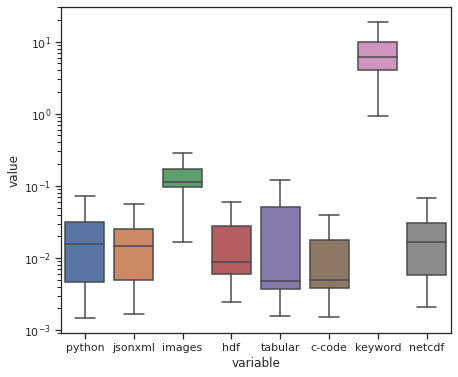

In [14]:
sns.set_theme(style="ticks")

f, ax = plt.subplots(figsize=(7, 6))
ax.set_yscale("log")
sns.boxplot(x="variable", y="value", data=pd.melt(df), showfliers=False)

In [18]:
df = pd.DataFrame()

df_dict = dict()

for k, v in times_dict.items():
	extract_df = pd.DataFrame.from_dict(v, orient='columns')
	extract_df.rename(columns={'time': k + ' time', 'success': k + ' success'}, inplace=True)
	df_dict[k] = extract_df

        python time  python success  jsonxml time  jsonxml success  \
0          0.016311             0.0      0.005888              0.0   
1          0.342545             0.0      0.040219              0.0   
2          0.316349             0.0      0.011902              0.0   
3          0.433763             0.0      0.053426              0.0   
4          0.008993             0.0      0.005042              0.0   
...             ...             ...           ...              ...   
214309     0.287629             0.0      0.007831              0.0   
214310     0.017761             0.0      0.061617              0.0   
214311     0.005877             0.0      0.006217              0.0   
214312     0.044655             0.0      0.017323              0.0   
214313     0.004388             0.0      0.019519              0.0   

        images time  images success  hdf time  hdf success  tabular time  \
0          1.537709             0.0  0.010767          0.0     20.235201   
1      

python
jsonxml
images
hdf
tabular
c-code
keyword
netcdf


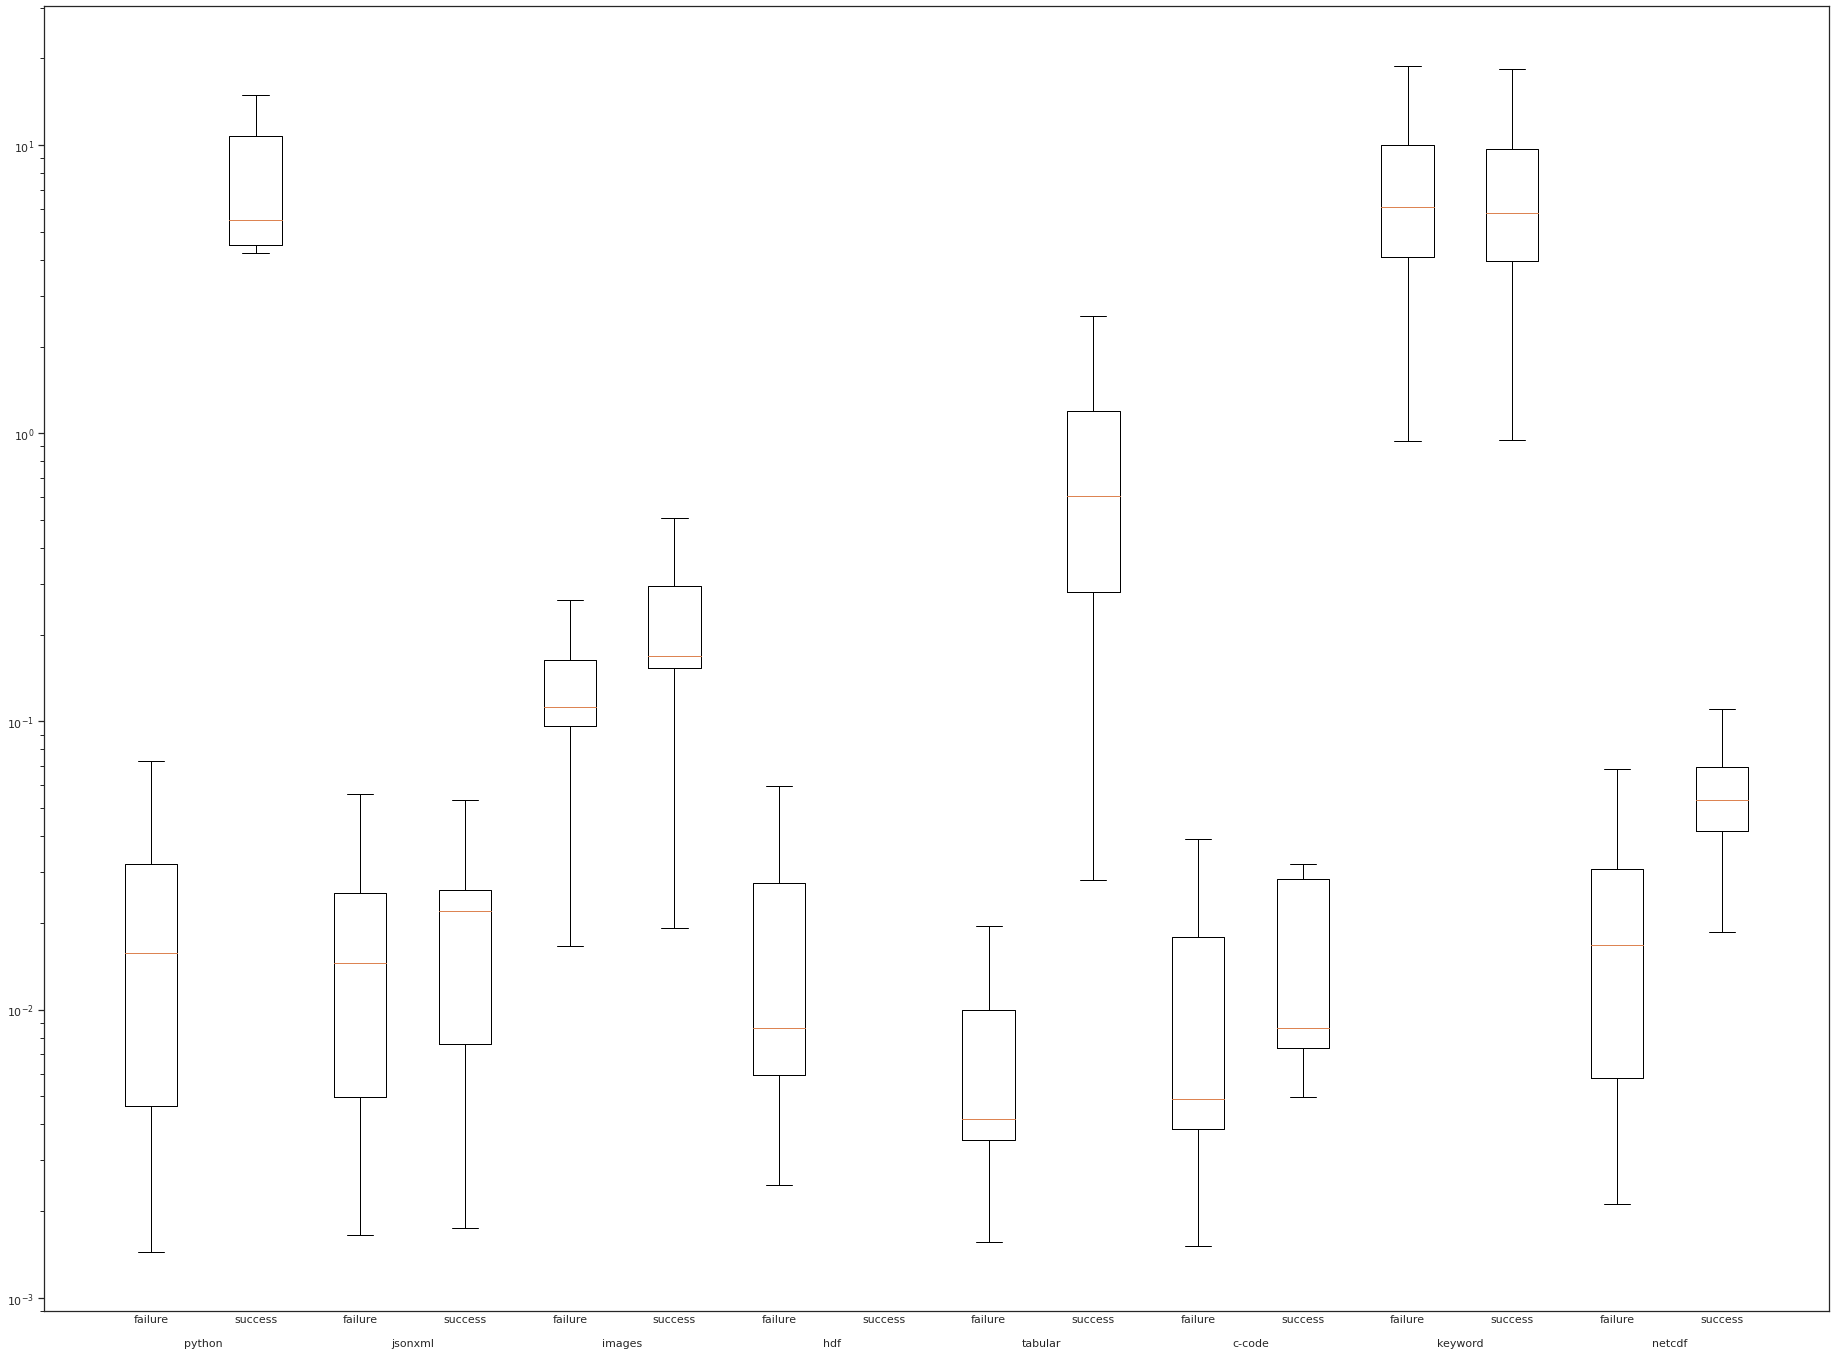

In [56]:
x = []
curr_pos = np.array([-400, -300])
fig = plt.figure(figsize=(32, 24))
ax = fig.add_subplot(111)
ax.set_yscale('log')


for k, v in df_dict.items():
	print(k)
	failure = v.loc[df[k + ' success'] == 0].loc[:,k + ' time']
	success = v.loc[df[k + ' success'] == 1].loc[:,k + ' time']

	plt.boxplot(np.array([failure.values, success.values], dtype=object),positions=curr_pos,widths=50, showfliers=False)
	
	x.append(curr_pos[0])
	x.append((curr_pos[0] + curr_pos[1]) / 2)
	x.append(curr_pos[1])

	curr_pos += 200


plt.xticks(x)
ax.tick_params(axis='x', which='both',length=0)
ax.set_xticklabels(('failure', '\n\npython', 'success', 'failure', '\n\njsonxml', 'success', 'failure', '\n\nimages', 'success', 
					'failure', '\n\nhdf', 'success', 'failure', '\n\ntabular', 'success', 'failure', '\n\nc-code', 'success', 
					'failure', '\n\nkeyword', 'success', 'failure', '\n\nnetcdf', 'success'), ha='center')


plt.show()
